# 概要
***
lightgbm x shap で二値分類の要因分析をおこなう  
【 参考 】  
- [評価指標](https://qiita.com/taiki_ohta/items/3f78dad94e96700ef0e6#accuracy-%E6%AD%A3%E7%AD%94%E7%8E%87)

# ライブラリ 

In [304]:
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns
import plotly
import plotly.express as px
from plotly.subplots import make_subplots

import lightgbm as lgb
import shap
shap.initjs()

In [305]:
li_lib = [pd, sklearn, lgb, shap, sns, plotly]
for lib in li_lib:
    print(lib.__name__, '：', lib.__version__)

pandas ： 1.3.4
sklearn ： 0.24.2
lightgbm ： 3.3.2
shap ： 0.41.0
seaborn ： 0.11.2
plotly ： 5.9.0


# データ 

In [306]:
df = sns.load_dataset('titanic')

In [307]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [309]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [310]:
df.isnull().sum() / df.shape[0]

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002245
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.772166
embark_town    0.002245
alive          0.000000
alone          0.000000
dtype: float64

In [311]:
y = df['survived']

In [312]:
y.value_counts()

0    549
1    342
Name: survived, dtype: int64

In [313]:
y.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: survived, dtype: float64

In [314]:
li_drop_col = ['survived', 'alive', 'who', 'embark_town']
X = df.drop(li_drop_col, axis=1)

li_not_number_columns = X.select_dtypes(exclude='number').columns
for col in li_not_number_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [315]:
X

,pclass,sex,age,sibsp,parch,fare,embarked,class,adult_male,deck,alone
0,3,1,22.0,1,0,7.2500,2,2,1,7,0
1,1,0,38.0,1,0,71.2833,0,0,0,2,0
2,3,0,26.0,0,0,7.9250,2,2,0,7,1
3,1,0,35.0,1,0,53.1000,2,0,0,2,0
4,3,1,35.0,0,0,8.0500,2,2,1,7,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,2,1,1,7,1
887,1,0,19.0,0,0,30.0000,2,0,0,1,1
888,3,0,NaN,1,2,23.4500,2,2,0,7,0
889,1,1,26.0,0,0,30.0000,0,0,1,2,1


In [316]:
X['age'].fillna(X['age'].median(), inplace=True)

In [318]:
# ホールドアウト
X_train, X_test, y_train, y_test = train_test_split(X, y)

# 学習

In [319]:
# 設定
eval_set = [(X_test, y_test), (X_train, y_train)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())

In [403]:
# インスタンス化 x 学習
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train, eval_set=eval_set, eval_metric='logloss', callbacks=callbacks)

[1]	training's binary_logloss: 0.62076	valid_0's binary_logloss: 0.609482
[2]	training's binary_logloss: 0.580445	valid_0's binary_logloss: 0.575204
[3]	training's binary_logloss: 0.54716	valid_0's binary_logloss: 0.547531
[4]	training's binary_logloss: 0.518843	valid_0's binary_logloss: 0.521527
[5]	training's binary_logloss: 0.494711	valid_0's binary_logloss: 0.502172
[6]	training's binary_logloss: 0.473151	valid_0's binary_logloss: 0.486694
[7]	training's binary_logloss: 0.45466	valid_0's binary_logloss: 0.472904
[8]	training's binary_logloss: 0.438289	valid_0's binary_logloss: 0.460893
[9]	training's binary_logloss: 0.423702	valid_0's binary_logloss: 0.45261
[10]	training's binary_logloss: 0.411836	valid_0's binary_logloss: 0.443514
[11]	training's binary_logloss: 0.400706	valid_0's binary_logloss: 0.437528
[12]	training's binary_logloss: 0.390792	valid_0's binary_logloss: 0.432058
[13]	training's binary_logloss: 0.382286	valid_0's binary_logloss: 0.426949
[14]	training's binary_lo

LGBMClassifier(random_state=42)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

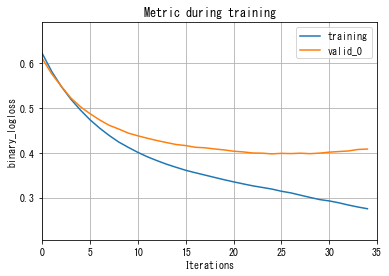

In [404]:
lgb.plot_metric(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

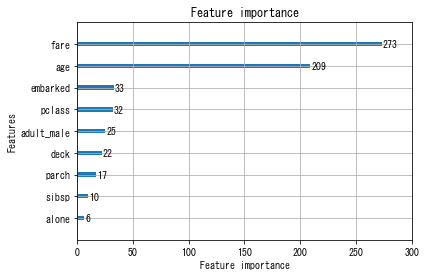

In [405]:
lgb.plot_importance(model)

# 予測 

In [406]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
y_pred_prob = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]

df_pred = pd.DataFrame()
df_pred['y_pred'] = y_pred
df_pred['y_pred_prob'] = y_pred_prob

In [407]:
df_pred

,y_pred,y_pred_prob
0,0,0.211541
1,0,0.136281
2,0,0.067331
3,0,0.085590
4,0,0.194751
...,...,...
218,0,0.160687
219,0,0.103465
220,0,0.454347
221,0,0.114202


In [408]:
# df_plot_eval = X_test.copy()
# df_plot_eval['y_pred'] = y_pred
# sns.pairplot(df_plot_eval, hue='y_pred')

# 評価 

In [409]:
# tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()
df_confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), columns=['pred_N', 'pred_P'], index=['true_N', 'true_P'])
df_confusion_matrix

,pred_N,pred_P
true_N,132,13
true_P,27,51


In [410]:
accuracy = metrics.accuracy_score(y_test, y_pred)
error_rate = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
fbeta = metrics.fbeta_score(y_test, y_pred, beta=0.5)
mcc = metrics.matthews_corrcoef(y_test, y_pred)

print(f'accuracy   : {accuracy:.4f}')
print(f'error rate : {error_rate:.4f}')
print(f'precision  : {precision:.4f}')
print(f'recall     : {recall:.4f}')
print(f'f1         : {f1:.4f}')
print(f'fbeta      : {fbeta:.4f}')
print(f'mcc        : {mcc:.4f}')

accuracy   : 0.8206
error rate : 0.1794
precision  : 0.7969
recall     : 0.6538
f1         : 0.7183
fbeta      : 0.7635
mcc        : 0.5948


In [411]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

fig = make_subplots(rows=1, cols=2)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={metrics.auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [412]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={metrics.auc(recall, precision):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

# SHAP

In [413]:
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

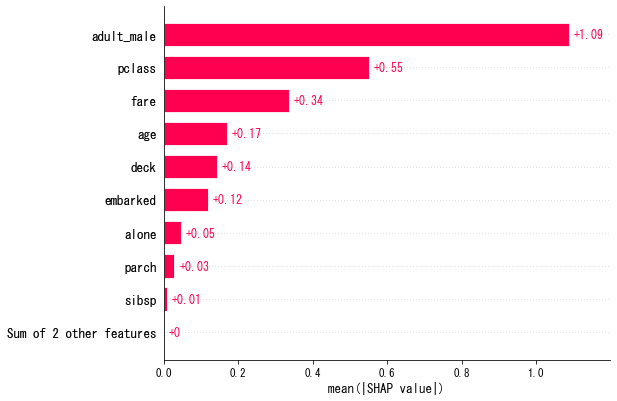

In [414]:
shap.plots.bar(shap_values)

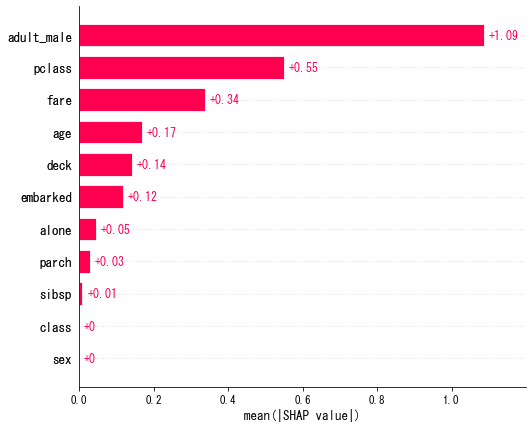

In [415]:
shap.plots.bar(shap_values, max_display=12)

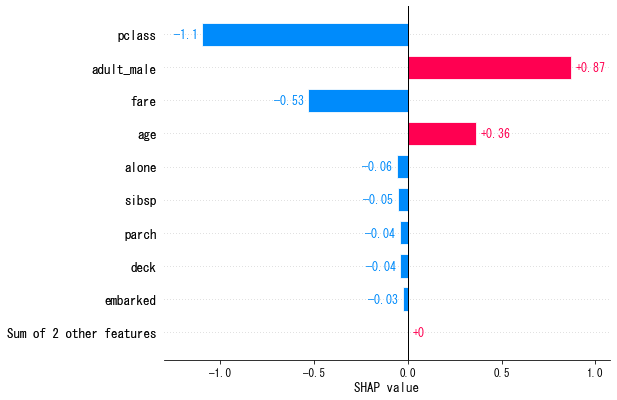

In [416]:
shap.plots.bar(shap_values[0])

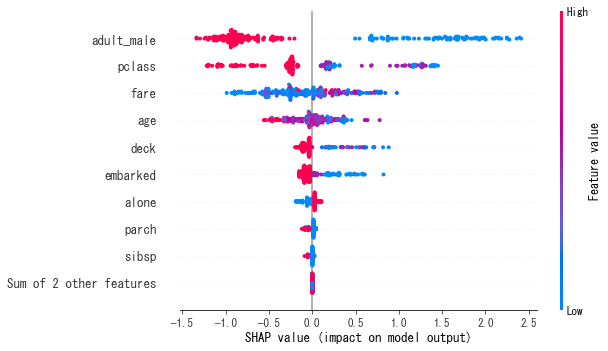

In [417]:
shap.plots.beeswarm(shap_values)

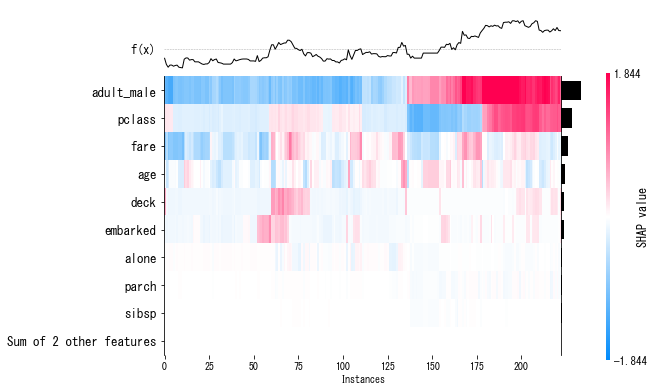

In [418]:
shap.plots.heatmap(shap_values)

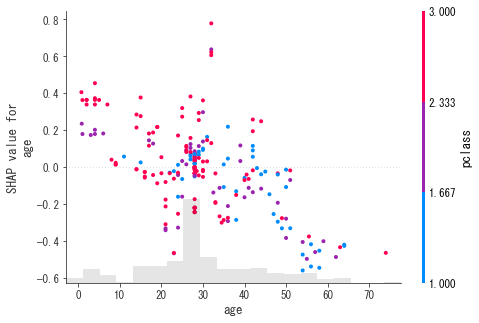

In [419]:
shap.plots.scatter(shap_values[:,"age"], color=shap_values)

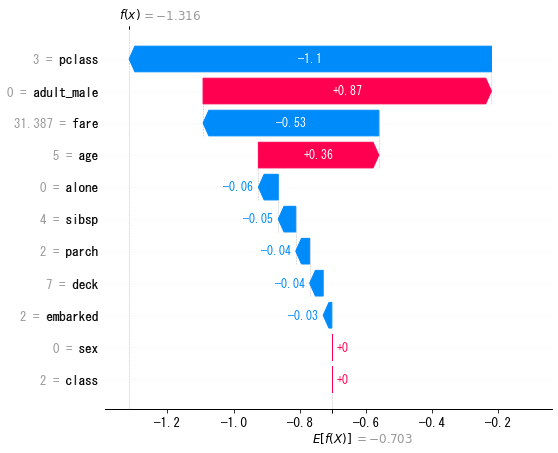

In [420]:
shap.plots.waterfall(shap_values[0], max_display=20)

In [424]:
shap.force_plot(shap_values, link='logit')

In [423]:
shap.force_plot(shap_values[0], link='logit')